In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

2022-08-11 11:04:59.151091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 11:04:59.151168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
input_df = pd.read_csv("input_data_nn.csv", sep=";")
output_df = pd.read_csv("output_data_nn.csv", sep=";")

df = pd.concat([input_df, output_df], axis=1)

In [3]:
cols = [
# 'pot_reativa_inj_barramento11',
# 'pot_reativa_inj_barramento12',
# 'pot_reativa_inj_barramento24',
 'pot_ativa_inj_barramento11',
 'pot_ativa_inj_barramento12',
 'pot_ativa_inj_barramento24',    
# 'tensao_barramento11',
# 'tensao_barramento12',
#  'tensao_barramento24',
  'carga_subrede_138kv',
  'pot_eolica_subrede_138kv',
  'pot_solar_subrede_138kv',
#  'status_1_gerador_subrede_230kv',
#  'status_2_gerador_subrede_230kv',
#  'status_3_gerador_subrede_230kv',
#  'status_4_gerador_subrede_230kv',
#  'status_5_gerador_subrede_230kv',
#  'status_6_gerador_subrede_230kv',
#  'status_7_gerador_subrede_230kv',
#  'status_8_gerador_subrede_230kv',
#  'status_9_gerador_subrede_230kv',
#  'status_10_gerador_subrede_230kv',
#  'status_11_gerador_subrede_230kv',
#  'status_12_gerador_subrede_230kv',
#  'status_13_gerador_subrede_230kv',
#  'status_14_gerador_subrede_230kv',
#  'status_15_gerador_subrede_230kv',
#  'status_16_gerador_subrede_230kv',
#  'status_17_gerador_subrede_230kv',
#  'status_18_gerador_subrede_230kv',
#  'status_1_linha_subrede_230kv',
#  'status_2_linha_subrede_230kv',
#  'status_3_linha_subrede_230kv',
#  'status_4_linha_subrede_230kv',
#  'status_5_linha_subrede_230kv',
#  'status_6_linha_subrede_230kv',
#  'status_7_linha_subrede_230kv',
#  'status_8_linha_subrede_230kv',
#  'status_9_linha_subrede_230kv',
#  'status_10_linha_subrede_230kv',
#  'status_11_linha_subrede_230kv',
#  'status_12_linha_subrede_230kv',
#  'status_13_linha_subrede_230kv',
#  'status_14_linha_subrede_230kv',
#  'status_15_linha_subrede_230kv',
#  'status_16_linha_subrede_230kv',
#  'status_17_linha_subrede_230kv',
#  'status_18_linha_subrede_230kv',
#  'status_19_linha_subrede_230kv',
#  'status_20_linha_subrede_230kv',
#  'status_21_linha_subrede_230kv'
]

In [4]:
class Analyze():
    
    def __init__(self, model_file, df, cols, days, max_id):
        self.model_file = model_file
        self.df = df[cols]
        self.days = days
        self.max_id = max_id
        
    def execute(self):
        model = keras.models.load_model(self.model_file)
        
        test_split = round(len(self.df)*0.30)
        df_for_training = self.df[:-test_split]
        df_for_testing = self.df[-test_split:]
        
        #self.scaler = MinMaxScaler(feature_range=(0,1))
        self.scaler = StandardScaler()
        df_for_training_scaled = self.scaler.fit_transform(df_for_training)
        df_for_testing_scaled = self.scaler.transform(df_for_testing)

        trainX, trainY = self.createXY(df_for_training_scaled, 24 * self.days)
        testX, testY = self.createXY(df_for_testing_scaled, 24 * self.days)
            
        prediction = model.predict(testX)
        pred = self.inverse_transform(testX, prediction)
        originals = self.inverse_transform(testX, testY)
        
        for i in range(self.max_id):
            error = self.mae(originals, pred, i)
            #rmse_error = self.rmse(originals, pred, i)
            print(f"MAE Error {i}: {error}")
            #print(f"RMSE Error {i}: {rmse_error}")

        
    def createXY(self, dataset, n_past):
        dataX = []
        dataY = []
        for i in range(n_past, len(dataset)):
                dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
                dataY.append(dataset[i, 0:self.max_id])
                
        return np.array(dataX), np.array(dataY)
    
    def inverse_transform(self, testX, arrs):
        zeros_padding = np.zeros(testX.shape[-1] - (self.max_id))
        arrs_copies = list(map(lambda arr: np.concatenate((arr, zeros_padding)), arrs))
        return self.scaler.inverse_transform(np.reshape(arrs_copies, (len(arrs), testX.shape[-1])))

    def mae(self, originals, pred, index):
        self._plot(originals[:,index], pred[:,index])
        return mean_absolute_error(originals[:,index], pred[:,index])
    
    def _plot(self, orig, pred):
        plt.plot(orig, color = 'red', label = 'Real')
        plt.plot(pred, color = 'blue', label = 'Predicted')
        plt.legend()
        plt.show()

    def rmse(self, originals, pred, index):
        #plot(originals[:,index], pred[:,index])
        return sqrt(mean_squared_error(originals[:,index], pred[:,index]))    

In [21]:
cols_1 = [
    #'pot_ativa_inj_barramento11',,
    # 'pot_ativa_inj_barramento24',  
    # 'pot_reativa_inj_barramento11',
     'pot_ativa_inj_barramento24',
    'pot_reativa_inj_barramento24',
    # 'pot_reativa_inj_barramento24',  
    # 'tensao_barramento11',
     'tensao_barramento24',
    # 'tensao_barramento24',
     'carga_subrede_138kv',
     'pot_eolica_subrede_138kv',
     'pot_solar_subrede_138kv'
]

cols_2 = [
    'pot_ativa_inj_barramento11',
    # 'pot_ativa_inj_barramento12',
    # 'pot_ativa_inj_barramento24',  
    # 'pot_reativa_inj_barramento11',
    # 'pot_reativa_inj_barramento12',
    # 'pot_reativa_inj_barramento24',  
#      'tensao_barramento11',
#      'tensao_barramento12',
#      'tensao_barramento24',
     'carga_subrede_138kv',
     'pot_eolica_subrede_138kv',
     'pot_solar_subrede_138kv'
]
cols_3 = [
    'pot_ativa_inj_barramento11',
    # 'pot_ativa_inj_barramento12',
    # 'pot_ativa_inj_barramento24',  
     'pot_reativa_inj_barramento11',
    # 'pot_reativa_inj_barramento12',
    # 'pot_reativa_inj_barramento24',  
     'tensao_barramento11',
    # 'tensao_barramento12',
    # 'tensao_barramento24',
     'carga_subrede_138kv',
     'pot_eolica_subrede_138kv',
     'pot_solar_subrede_138kv'
]

79/79 [==============================] - 4s 39ms/step


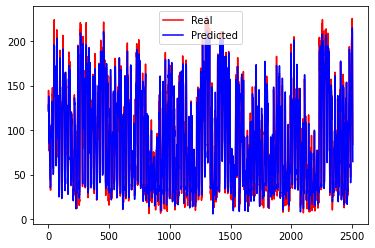

MAE Error 0: 12.809887626207384


In [24]:
Analyze('models/bus-24-active-only-5batch.h5', df, cols_1, 5, 1).execute()